# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

- **User_input**: user inputs tokenized without preprocessing
- **User_input_preprocessed**: user inputs tokenized with preprocessing
- **User_input_preprocessed_stem**: user inputs tokenized with preprocessing and stemming
- **User_input_preprocessed_lem** : user inputs tokenized with preprocessing and lematization

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, log_loss
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Reshape, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed


#### Run with GPU


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Data Load

In [2]:
datapath = "Data/dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [3]:
display(data)

,Disease,User_input
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
10599,Dermatitis,The discomfort in my skin has made it challeng...
10600,Dermatitis,"The raw, sensitive skin from scratching has ma..."
10601,Dermatitis,"I feel like my skin is tearing apart, causing ..."
10602,Dermatitis,Engaging in physical activities has become unb...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10604 entries, 0 to 10603
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10604 non-null  object
 1   User_input  10604 non-null  object
dtypes: object(2)
memory usage: 165.8+ KB


In [5]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10604 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


Psoriasis : 2184 samples
Melanoma : 2070 samples
Urticaria : 2216 samples
Lupus : 1868 samples
Dermatitis : 2266 samples


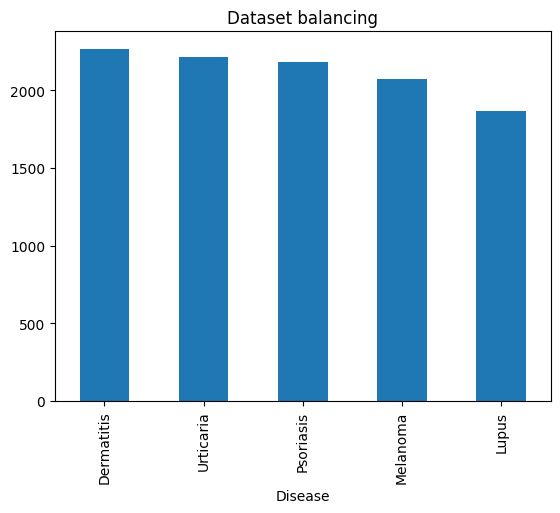

In [6]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

# Print count for each disease
for disease in data['Disease'].unique():
    print(f"{disease} : {data[data['Disease'] == disease].shape[0]} samples")

## Model Evaluation

In [ ]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

    # Loss
    print("\n\033[1mLoss\033[0m")
    y_pred_proba = model.predict_proba(X_Test)
    # Calculate the log loss
    loss = log_loss(y_test, y_pred_proba)
    print(f"Log loss: {loss}")

    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

    #return test f1score
    return f1_score(y_test, y_test_pred, average='weighted')


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy, f1_score = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)
    print("F1-Score: ", f1_score)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [7]:
data['User_input_preprocessed'] = data['User_input']

- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [8]:
# Load english stop words using stopwords
# nltk.download('stopwords')

# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')

## Data Visualization

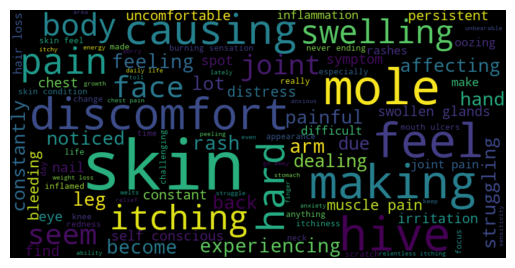

In [9]:
# General word cloud
word_list = " ".join(text for text in data['User_input'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

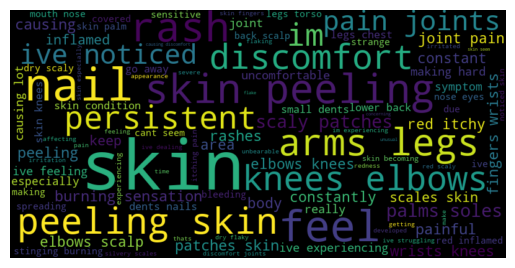

In [10]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

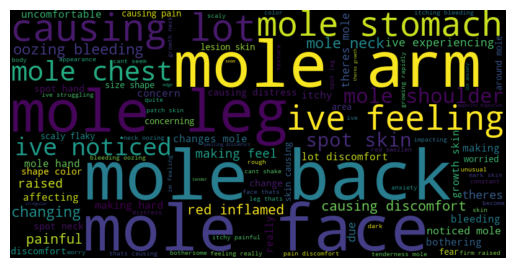

In [11]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

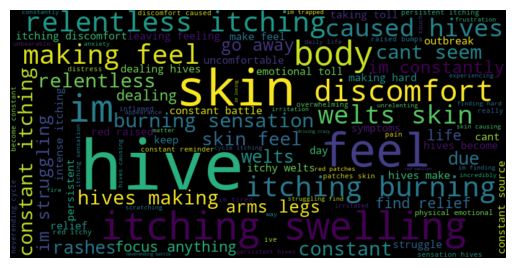

In [12]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

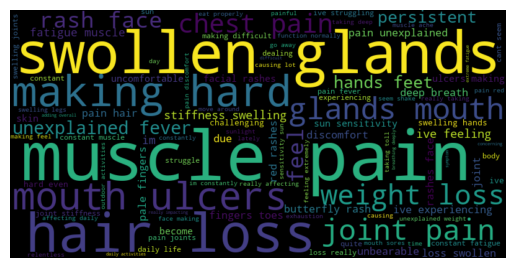

In [13]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

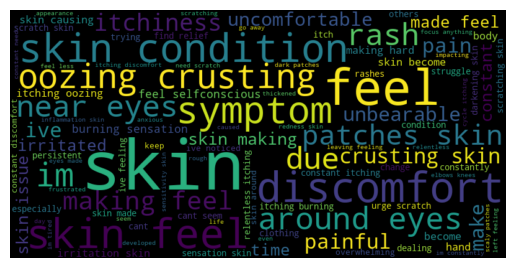

In [14]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenization

In [ ]:
# Tokenization by white space
#tokenizer = nltk.tokenize.WhitespaceTokenizer()
#data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
#tokenizer = nltk.tokenize.TreebankWordDetokenizer()
#data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
#tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


## Stemming & Lamitization

### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [ ]:
#nltk.download('wordnet')

In [15]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))
data['User_input'] = data['User_input'].apply(lambda x: tokenizer.tokenize(x))

In [16]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_preprocessed_stem'] = data['User_input_preprocessed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [17]:
# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_preprocessed_lem'] = data['User_input_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [12]:
display(data)

,Disease,User_input,User_input_preprocessed,User_input_preprocessed_stem,User_input_preprocessed_lem
0,Psoriasis,"[I, have, been, experiencing, a, skin, rash, o...","[experiencing, skin, rash, arms, legs, torso, ...","[experienc, skin, rash, arm, leg, torso, past,...","[experiencing, skin, rash, arm, leg, torso, pa..."
1,Psoriasis,"[My, skin, has, been, peeling,, especially, on...","[my, skin, peeling, especially, knees, elbows,...","[my, skin, peel, especi, knee, elbow, scalp, t...","[my, skin, peeling, especially, knee, elbow, s..."
2,Psoriasis,"[I, have, been, experiencing, joint, pain, in,...","[experiencing, joint, pain, fingers, wrists, k...","[experienc, joint, pain, finger, wrist, knee, ...","[experiencing, joint, pain, finger, wrist, kne..."
3,Psoriasis,"[There, is, a, silver, like, dusting, on, my, ...","[there, silver, like, dusting, skin, especiall...","[there, silver, like, dust, skin, especi, lowe...","[there, silver, like, dusting, skin, especiall..."
4,Psoriasis,"[My, nails, have, small, dents, or, pits, in, ...","[my, nails, small, dents, pits, them, often, f...","[my, nail, small, dent, pit, them, often, feel...","[my, nail, small, dent, pit, them, often, feel..."
...,...,...,...,...,...
10599,Dermatitis,"[The, discomfort, in, my, skin, has, made, it,...","[the, discomfort, skin, made, challenging, par...","[the, discomfort, skin, made, challeng, partak...","[the, discomfort, skin, made, challenging, par..."
10600,Dermatitis,"[The, raw,, sensitive, skin, from, scratching,...","[the, raw, sensitive, skin, scratching, made, ...","[the, raw, sensit, skin, scratch, made, unbear...","[the, raw, sensitive, skin, scratching, made, ..."
10601,Dermatitis,"[I, feel, like, my, skin, is, tearing, apart,,...","[feel, like, skin, tearing, apart, causing, ex...","[feel, like, skin, tear, apart, caus, excruci,...","[feel, like, skin, tearing, apart, causing, ex..."
10602,Dermatitis,"[Engaging, in, physical, activities, has, beco...","[engaging, physical, activities, become, unbea...","[engag, physic, activ, becom, unbear, due, sen...","[engaging, physical, activity, become, unbeara..."


## Embeddings

### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [ ]:
boW = CountVectorizer(stop_words='english')

bow_normal = boW.fit(data['User_input'].apply(' '.join))

bow_preprocessed = boW.fit(data["User_input_preprocessed"].apply(' '.join))

bow_lem = boW.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_stem = boW.fit(data['User_input_preprocessed_stem'].apply(' '.join))


We think that to understand the symptoms is important to use n-grams

In [ ]:
bow_ngram = CountVectorizer(stop_words='english', ngram_range=(1,3))

bow_ngram_normal = bow_ngram.fit(data['User_input'].apply(' '.join))

bow_ngram_preprocessed = bow_ngram.fit(data["User_input_preprocessed"].apply(' '.join))

bow_ngram_lem = bow_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_ngram_stem = bow_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


### TF-IDF

In [ ]:
tf_idf = TfidfVectorizer()

tf_idf_normal = tf_idf.fit(data['User_input'].apply(' '.join))

tf_idf_preprocessed = tf_idf.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_lem = tf_idf.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_stem = tf_idf.fit(data['User_input_preprocessed_stem'].apply(' '.join))

# Save fited vectorizer
#joblib.dump(tf_idf_stem, 'Vectorizer/tfidf_stem.pkl')
#joblib.dump(tf_idf_lem, 'Vectorizer/tfidf_lem.pkl')

In [ ]:
tf_idf_ngram = TfidfVectorizer(ngram_range=(1,3))

tf_idf_ngram_normal = tf_idf_ngram.fit(data['User_input'].apply(' '.join))

tf_idf_ngram_preprocessed = tf_idf_ngram.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_ngram_lem = tf_idf_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_ngram_stem = tf_idf_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))

## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [13]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8483 rows and 5 columns.
Test dataset contains 2121 rows and 5 columns.


In [ ]:
display(train)

#### Define X

##### BoW

In [ ]:
# without preprocessing
X_train_bow_noproc = bow_normal.transform(train['User_input'].apply(' '.join))
X_test_bow_noproc = bow_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_bow_proc = bow_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_bow_proc = bow_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_bow_stem = bow_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_bow_stem = bow_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_bow_lem = bow_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_bow_lem = bow_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### Bow Ngram

In [ ]:
# without preprocessing
X_train_ngram_noproc = bow_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_ngram_noproc = bow_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_ngram_proc = bow_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_ngram_proc = bow_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_ngram_stem = bow_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_ngram_stem = bow_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_ngram_lem = bow_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_ngram_lem = bow_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### TF-IDF

In [ ]:
# without preprocessing
X_train_tfidf_noproc = tf_idf_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_noproc = tf_idf_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_proc = tf_idf_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_proc = tf_idf_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_stem = tf_idf_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_stem = tf_idf_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_lem = tf_idf_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_lem = tf_idf_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

In [ ]:
features = tf_idf_stem.get_feature_names_out()

weights = np.asarray(X_train_tfidf_stem.mean(axis=0)).ravel()

features_weights = list(zip(features, weights))
features_weights.sort(key = lambda x: x[1], reverse = True)

top_features = features_weights[:20]
for feature, weight in top_features:
    print(f"Feature: {feature}, Weight: {weight}")

##### TF-IDF N-gram

In [ ]:
# without preprocessing
X_train_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_ngram_stem = tf_idf_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_ngram_stem = tf_idf_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_ngram_lem = tf_idf_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_ngram_lem = tf_idf_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

#### Define Y

In [ ]:
y_train = train['Disease']
y_test = test['Disease']

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

In [ ]:
best_score_lr = 0
best_modeltype_lr = ""
best_model = None

##### Hyperopt

In [ ]:
def hyperopt_lr(X_train):
    space = {
        'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
        'penalty': hp.choice('penalty', ['l2']),
        'C': hp.uniform('C', 1.0, 10.0),
        'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
    }

    def objective(params):
        clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'],
                                 max_iter=params['max_iter'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe_algorithm,
                max_evals=50,
                trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params


##### Grid Search

In [ ]:
def grid_search_lr(X_train):
    lr = LogisticRegression()

    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['lbfgs','newton-cg','sag'],
            'penalty': ['l2',],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': np.arange(1.0, 10.0, 1.0),
            'l1_ratio': [0.1, 0.5, 0.9],  # Add l1_ratio here
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
            'penalty': [None],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        }
    ]

    grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    return grid.best_params_


##### Run Model

In [ ]:
def model_lr(best_param, X_train, X_test, model_type):
    global best_score_lr, best_modeltype_lr, best_model
    
    lr = LogisticRegression(solver=best_param['solver'], penalty=best_param['penalty'], C=best_param['C'], max_iter=best_param['max_iter'])
    lr.fit(X_train, y_train)
    score = evaluate(lr, X_train, X_test, y_train, y_test)
    
    if score > best_score_lr:
        best_score_lr = score
        best_modeltype_lr = model_type
        best_model = lr

##### Without Preprocessing

In [ ]:
name = "LR_withoutyproc_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [ ]:
name = "LR_withproc_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [ ]:
name = "LR_lem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### With stemming

In [ ]:
name = "LR_stem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/LR/{best_modeltype_lr}.pkl')
print(best_score_lr)

#### Naive Bayes

**Important Parameters:**
- Alpha
- Fit Prior
- Class Prior

In [ ]:
best_score_nb = 0
best_modeltype_nb = ""
best_model = None

##### Random Search ####

In [ ]:
def random_search_nb(X_train):
    param_grid = {
        'alpha': np.random.uniform(0.0, 2.0, 50),
        'fit_prior': [True, False],
        'class_prior': [None] + [np.random.dirichlet(np.ones(np.unique(y_train).shape[0])) for _ in range(50)]
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        clf = MultinomialNB(alpha=params['alpha'], fit_prior=params['fit_prior'], class_prior=params['class_prior'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return score

    num_iterations = 50
    for _ in range(num_iterations):
        params = {k: np.random.choice(v) if k != 'class_prior' else v[np.random.randint(len(v))] for k, v in param_grid.items()}
        score = evaluate_params(params)
        if score > best_score:
            best_score = score
            best_params = params
    
    print("Best hyperparameters:", best_params)
    return best_params


##### Run Model

In [ ]:
def model_nb(best_param, X_train, X_test, model_type):

    global best_score_nb, best_modeltype_nb, best_model

    nb = MultinomialNB(alpha=best_param['alpha'], fit_prior=best_param['fit_prior'], class_prior=best_param['class_prior'])
    nb.fit(X_train, y_train)
    score = evaluate(nb, X_train, X_test, y_train, y_test)
    if score > best_score_nb:
        best_score_nb = score
        best_modeltype_nb = model_type
        best_model = nb

##### Without Preprocessing

In [ ]:
name = "NB_withoutyproc_"

**BoW** 

In [ ]:
best_params = random_search_nb(X_train_bow_noproc)
model_nb(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_nb(X_train_ngram_noproc)
model_nb(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = random_search_nb(X_train_tfidf_noproc)
model_nb(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_nb(X_train_tfidf_ngram_noproc)
model_nb(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [ ]:
name = "NB_withproc_"

**BoW** 

In [ ]:
best_params = random_search_nb(X_train_bow_proc)
model_nb(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_nb(X_train_ngram_proc)
model_nb(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_nb(X_train_tfidf_proc)
model_nb(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_nb(X_train_tfidf_ngram_proc)
model_nb(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lematization

In [ ]:
name = "NB_lem_"

**BoW** 

In [ ]:
best_params = random_search_nb(X_train_bow_lem)
model_nb(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_nb(X_train_ngram_lem)
model_nb(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_nb(X_train_tfidf_lem)
model_nb(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_nb(X_train_tfidf_ngram_lem)
model_nb(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [ ]:
name = "NB_stem_"

**BoW** 

In [ ]:
best_params = random_search_nb(X_train_bow_stem)
model_nb(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_nb(X_train_ngram_stem)
model_nb(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_nb(X_train_tfidf_stem)
model_nb(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_nb(X_train_tfidf_ngram_stem)
model_nb(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/NB/{best_modeltype_nb}.pkl')
print(best_score_nb)

#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

In [ ]:
best_score_svm = 0
best_modeltype_svm = ""
best_model = None

In [ ]:
def train_and_evaluate(params, X_train, y_train):
    clf = SVC(**params)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

##### Random Search #####

In [ ]:
def random_search_svm(X_train):
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        score = train_and_evaluate(params, X_train, y_train)
        return score

    num_iterations = 50
    num_jobs = 4  # Número de trabalhos em paralelo
    results = Parallel(n_jobs=num_jobs)(delayed(evaluate_params)({k: np.random.choice(v) for k, v in param_grid.items()}) for _ in range(num_iterations))
    
    best_index = np.argmax(results)
    best_params = {k: np.random.choice(v) for k, v in param_grid.items()}
    best_score = results[best_index]
    
    print("Best hyperparameters:", best_params)
    return best_params

##### Run Model

In [ ]:
def model_svm(best_param, X_train, X_test, model_type):

    global best_score_svm, best_modeltype_svm, best_model

    svm = SVC(probability=True,C=best_param['C'], gamma = best_param['gamma'], kernel=best_param['kernel'])
    svm.fit(X_train, y_train)
    score = evaluate(svm, X_train, X_test, y_train, y_test)
    if score > best_score_svm:
        best_score_svm = score
        best_modeltype_svm = model_type
        best_model = svm

##### Without Preprocessing

In [ ]:
name = "SVM_withoutyproc_"

**BoW** 

In [ ]:
best_params = random_search_svm(X_train_bow_noproc)
model_svm(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_svm(X_train_ngram_noproc)
model_svm(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_svm(X_train_tfidf_noproc)
model_svm(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_noproc)
model_svm(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [ ]:
name = "SVM_withproc_"

**BoW** 

In [ ]:
best_params = random_search_svm(X_train_bow_proc)
model_svm(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_svm(X_train_ngram_proc)
model_svm(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_svm(X_train_tfidf_proc)
model_svm(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_proc)
model_svm(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [ ]:
name = "SVM_lem_"

**BoW** 

In [ ]:
best_params = random_search_svm(X_train_bow_lem)
model_svm(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_svm(X_train_ngram_lem)
model_svm(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_svm(X_train_tfidf_lem)
model_svm(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_lem)
model_svm(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [ ]:
name = "SVM_stem_"

**BoW** 

In [ ]:
best_params = random_search_svm(X_train_bow_stem)
model_svm(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = random_search_svm(X_train_ngram_stem)
model_svm(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = random_search_svm(X_train_tfidf_stem)
model_svm(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_stem)
model_svm(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/SVM/{best_modeltype_svm}.pkl')
print(best_score_svm)

### Deep Learning

In [ ]:
def preprocessing_dl(vocab_size, mean_length, X_train, X_test):
    tokenizer = Tokenizer(num_words=vocab_size,oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Convert texts to sequences
    seq_train = tokenizer.texts_to_sequences(X_train.apply(' '.join))
    seq_test = tokenizer.texts_to_sequences(X_test.apply(' '.join))

    # Pad the sequences to the same size
    pad_train = pad_sequences(seq_train, maxlen = mean_length)
    pad_test = pad_sequences(seq_test, maxlen = mean_length)

    word_index = tokenizer.word_index
    print(len(word_index))
    return pad_train, pad_test


In [ ]:
# Convert labels into numeric
diseases = {
    'Dermatitis': 0,
    'Lupus': 1,
    'Melanoma': 2,
    'Psoriasis': 3,
    'Urticaria': 4
}

# Create array with numeric diseases
train_labels = np.array(
    [diseases[label] for label in train['Disease']])
test_labels = np.array(
    [diseases[label] for label in test['Disease']])

from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [ ]:
def analyse_data(data):
    words = set()

    for sentence in data:
        for word in sentence:
            words.add(word)

    num_unique_words = len(words)
    print(f"Number of unique words: {num_unique_words}")

    mean_length = int(data.apply(len).max())
    print(f"Max length: {mean_length}")

    return num_unique_words, mean_length

#### Recurrent Neural Network

##### Model

embedding_dimensions =  number_of_categories**0.25

https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html


In [ ]:
def RNN_model(embedding_dim,vocab_size,pad_train,pad_test,proc_type):
    
    rnn = Sequential(name="Basic_RNN")
    rnn.add(Embedding(vocab_size, embedding_dim)) 
    rnn.add(SimpleRNN(128, activation='tanh', return_sequences=True))
    rnn.add(SimpleRNN(64, activation='tanh', return_sequences=False))
    rnn.add(Dense(32, activation='relu'))
    rnn.add(Dense(5, activation='softmax'))

    rnn.build(input_shape=(None, pad_train.shape[1]))

    print(rnn.summary())

    rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])

    history = rnn.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        batch_size=16,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(rnn, history, pad_test, test_labels)
    rnn.save('Models/RNN/rnn_'+ proc_type + '.keras')

##### Without Preprocessing

In [ ]:
vocab_size, max_length = analyse_data(data['User_input'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, max_length , train['User_input'] , test['User_input'])

RNN_model(100,vocab_size, pad_train, pad_test, 'withoutproc')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, max_length , train['User_input'], test['User_input'])

RNN_model(200,vocab_size, pad_train, pad_test, 'withoutproc')

##### With Preprocessing

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(200, vocab_size, pad_train, pad_test, 'withproc')

##### With Lemmatization

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(200, vocab_size, pad_train, pad_test, 'withproc_lem')

##### With Stemming

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

In [ ]:

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(200, vocab_size, pad_train, pad_test, 'withproc_stem')

#### Conv 1D

In [ ]:
def Conv1D_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 200

    # Create Conv1D model for text classification
    conv1d = Sequential(name="Conv1D")
    conv1d.add(Embedding(vocab_size, embedding_dim))
    conv1d.add(Conv1D(128,4))
    conv1d.add(GlobalMaxPooling1D())
    conv1d.add(Dense(32, activation='relu'))
    conv1d.add(Dense(5, activation='softmax'))

    conv1d.build(input_shape=(None, pad_train.shape[1]))

    print(conv1d.summary())

    conv1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])

    history = conv1d.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        batch_size=12,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(conv1d, history, pad_test, test_labels)
    conv1d.save('Models/Conv1D/conv_'+ proc_type + '.keras')


##### Without Preprocessing

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input'], test['User_input'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withoutproc')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input'], test['User_input'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withoutproc')

##### With Preprocessing

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc')

##### With Lemmatization

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_lem')

##### With Stemming

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### LSTM

In [ ]:
def LSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 200

    # Create LSTM model for text classification
    lstm = Sequential(name="LSTM")
    lstm.add(Embedding(vocab_size, embedding_dim))
    lstm.add(LSTM(32))
    lstm.add(Dropout(0.4))
    lstm.add(Dense(5, activation='softmax'))

    lstm.build(input_shape=(None, pad_train.shape[1]))

    print(lstm.summary())

    lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])

    history = lstm.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        batch_size=16,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(lstm, history, pad_test, test_labels)
    lstm.save('Models/LSTM/LSTM_'+ proc_type + '.keras')

**Without Preprocessing**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input'], test['User_input'])

LSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input'], test['User_input'])

LSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

In [ ]:

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

In [ ]:

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### BILSTM

In [ ]:
def BiLSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 100

    # Create LSTM model for text classification
    blstm = Sequential(name="Bi_LSTM")
    blstm.add(Embedding(vocab_size, embedding_dim))
    blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
    blstm.add(Dropout(0.4))
    blstm.add(Bidirectional(LSTM(32)))
    blstm.add(Dropout(0.2))
    blstm.add(Dense(64, activation='relu'))
    blstm.add(Dropout(0.1))
    blstm.add(Dense(5, activation='softmax'))

    blstm.build(input_shape=(None, pad_train.shape[1]))

    print(blstm.summary())

    blstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])

    history = blstm.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        batch_size=16,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(blstm, history, pad_test, test_labels)
    blstm.save('Models/BILSTM/BILSTM_'+ proc_type + '.keras')

**Without Preprocessing**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input'])

In [ ]:
pad_train, pad_test = preprocessing_dl( vocab_size, mean_length , train['User_input'], test['User_input'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

In [ ]:
pad_train, pad_test = preprocessing_dl( vocab_size, mean_length , train['User_input'], test['User_input'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')